In [34]:
# Standard library imports
import warnings
from collections import Counter
from datetime import datetime, timedelta

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed
from scipy.special import boxcox1p
from scipy.stats import boxcox, boxcox_normmax, skew, stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, 
                             precision_recall_fscore_support, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# Optuna specific imports
import optuna
from optuna.visualization import plot_optimization_history
from optuna.exceptions import TrialPruned

import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.backends.backend_pdf import PdfPages

import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.backends.backend_pdf import PdfPages
import pickle

# Setting warnings to ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [35]:
df = pd.read_csv('../data/BitcoinHeistData.csv') 

In [3]:
predictor_variables = ['year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']
correlation_matrix = df[predictor_variables].corr()
X = df[predictor_variables]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

    Variable       VIF
0       year  0.000006
1        day  1.000255
2     length  1.987532
3     weight  1.928872
4      count  2.400960
5     looped  1.464397
6  neighbors  1.954434
7     income  1.021909


In [4]:
# Check the dimensions of the dataset
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

# Display the first few rows of the dataset
print(df.head())

# Get the column names
print("Column names:", df.columns)

# Check the data types of the columns
print(df.dtypes)


Number of rows: 2916697
Number of columns: 10
                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income            label  
0       0          2  100050000.0  princetonCerber  
1       0          1  100000000.0   princetonLocky  
2       0          2  200000000.0  princetonCerber  
3       0          2   71200000.0  princetonCerber  
4       0          1  200000000.0   princetonLocky  
Column names: Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label'],
      dtype='object')
address       object
year

In [5]:
df.label.value_counts()

white                          2875284
paduaCryptoWall                  12390
montrealCryptoLocker              9315
princetonCerber                   9223
princetonLocky                    6625
montrealCryptXXX                  2419
montrealNoobCrypt                  483
montrealDMALockerv3                354
montrealDMALocker                  251
montrealSamSam                      62
montrealCryptoTorLocker2015         55
montrealGlobeImposter               55
montrealGlobev3                     34
montrealGlobe                       32
montrealWannaCry                    28
montrealRazy                        13
montrealAPT                         11
paduaKeRanger                       10
montrealFlyper                       9
montrealXTPLocker                    8
montrealXLockerv5.0                  7
montrealVenusLocker                  7
montrealCryptConsole                 7
montrealEDA2                         6
montrealJigSaw                       4
paduaJigsaw              

               year           day        length        weight         count  \
count  2.916697e+06  2.916697e+06  2.916697e+06  2.916697e+06  2.916697e+06   
mean   2.014475e+03  1.814572e+02  4.500859e+01  5.455192e-01  7.216446e+02   
std    2.257398e+00  1.040118e+02  5.898236e+01  3.674255e+00  1.689676e+03   
min    2.011000e+03  1.000000e+00  0.000000e+00  3.606469e-94  1.000000e+00   
25%    2.013000e+03  9.200000e+01  2.000000e+00  2.148438e-02  1.000000e+00   
50%    2.014000e+03  1.810000e+02  8.000000e+00  2.500000e-01  1.000000e+00   
75%    2.016000e+03  2.710000e+02  1.080000e+02  8.819482e-01  5.600000e+01   
max    2.018000e+03  3.650000e+02  1.440000e+02  1.943749e+03  1.449700e+04   

             looped     neighbors        income  
count  2.916697e+06  2.916697e+06  2.916697e+06  
mean   2.385067e+02  2.206516e+00  4.464889e+09  
std    9.663217e+02  1.791877e+01  1.626860e+11  
min    0.000000e+00  1.000000e+00  3.000000e+07  
25%    0.000000e+00  1.000000e+00  7.4

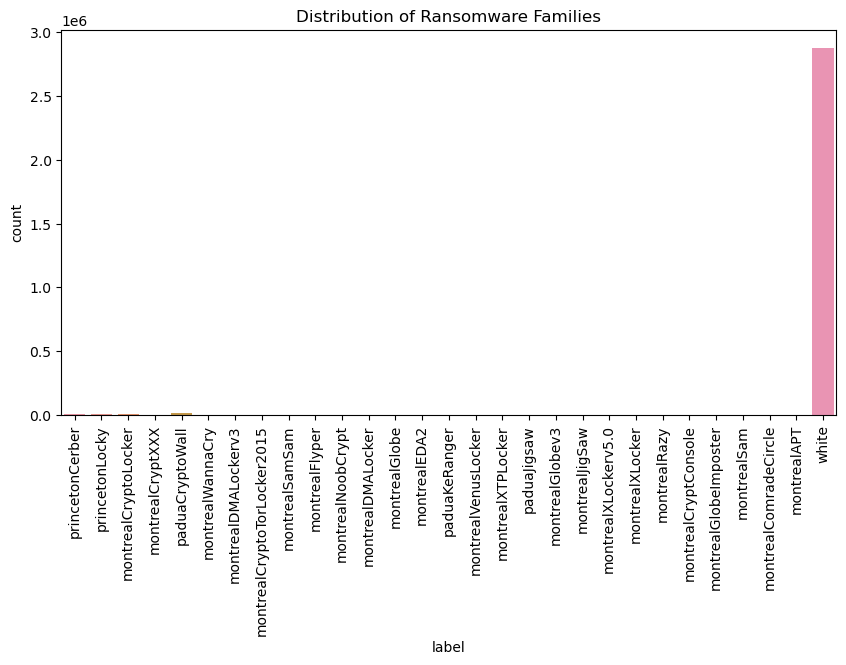

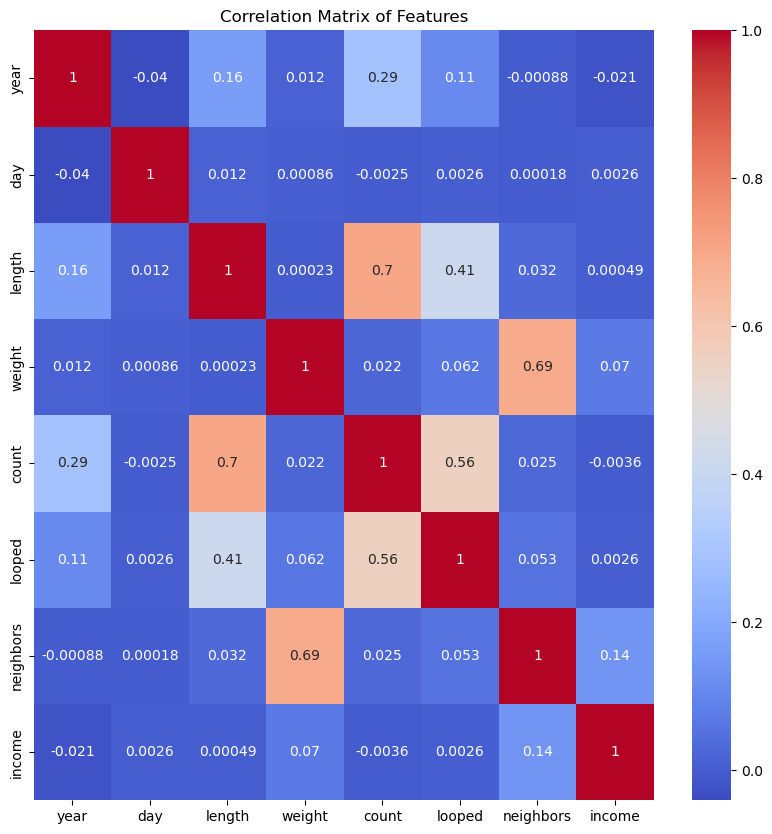

In [6]:
# Data description
print(df.describe())

# Check the distribution of ransomware families
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='label')
plt.title('Distribution of Ransomware Families')
plt.xticks(rotation=90)
plt.show()

# Check the correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


The correlation matrix you've provided shows the relationships between different features in your dataset. Here are a few observations and potential actions you might consider:

1. **High Correlation**: The features 'count', 'looped', and 'neighbors' have a high positive correlation with each other. This means they tend to increase or decrease together. Similarly, 'length' and 'weight' also show a high positive correlation. High correlation between features can sometimes lead to problems with multicollinearity in certain types of models, particularly linear regression models. If you plan to use such a model, you might consider removing one feature from each pair of highly correlated features, or combining them in some way.

2. **Low Correlation**: The features 'year', 'day', and 'income' show very low correlation with other features. This isn't necessarily a problem, but it's worth noting that these features may not contribute much to a model that heavily relies on relationships between features, such as linear regression.

3. **Correlation with Target Variable**: If 'label' is your target variable, you should also consider its correlation with other features. Features with very low correlation with the target variable might not be very useful for prediction.

Remember, these are just potential actions based on the correlation matrix. The actual actions you should take depend on the specific requirements of your machine learning model and the nature of your data. It's also important to remember that correlation does not imply causation – just because two features are correlated does not necessarily mean that one causes the other to change.

Based on the overview of the data you've provided, here are a few observations and potential actions:

1. **Outliers**: The 'count', 'looped', 'neighbors', and 'income' columns have a maximum value that is significantly higher than the 75th percentile. This could indicate the presence of outliers in these columns. Outliers can sometimes negatively affect the performance of a machine learning model, especially if they represent errors or anomalies rather than just extreme values. You might consider using a method like the IQR score or Z-score to detect and handle these outliers.

2. **Skewness**: The 'count', 'looped', 'neighbors', and 'income' columns also have a mean that is significantly higher than the median. This could indicate that these columns are right-skewed. Depending on the machine learning model you're using, you might need to transform these columns to reduce skewness. Common methods for this include log transformation, square root transformation, or box-cox transformation.

3. **Scale of Features**: The features have different scales, with 'year' and 'day' being in the range of hundreds, while 'count', 'looped', 'neighbors', and 'income' are in the range of thousands to millions. Many machine learning models perform better when all features are on a similar scale. You might consider using feature scaling methods like normalization or standardization.

4. **Missing Values**: It doesn't appear that there are any missing values in the dataset, which is good. If there were missing values, you would need to decide how to handle them.

Remember, these are just potential actions based on the overview of the data. The actual actions you should take depend on the specific requirements of your machine learning model and the nature of your data.

In [7]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()

address      0
year         0
day          0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
dtype: int64


# Preprocessing

In [8]:
# Label encoding for 'address' feature
le = preprocessing.LabelEncoder()
df['address'] = le.fit_transform(df['address'])

# family categories
df.loc[df['label'].str.startswith("m"),'label']="Montreal"
df.loc[df['label'].str.startswith("pa"),'label']="Panuda"
df.loc[df['label'].str.startswith("pr"),'label']="Princeton"
df.loc[df['label'].str.startswith("w"),'label']="White"

# Encode target labels with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['label'])

for class_, label in enumerate(le.classes_):
    print(f'The label {label} is encoded as {class_}')

class_distribution = df['label'].value_counts()
print(class_distribution)

The label Montreal is encoded as 0
The label Panuda is encoded as 1
The label Princeton is encoded as 2
The label White is encoded as 3
3    2875284
2      15848
0      13163
1      12402
Name: label, dtype: int64


In [9]:
df

,address,year,day,length,weight,count,looped,neighbors,income,label
0,23,2017,11,18,0.008333,1,0,2,1.000500e+08,2
1,128,2016,132,44,0.000244,1,0,1,1.000000e+08,2
2,169,2016,246,0,1.000000,1,0,2,2.000000e+08,2
3,217,2016,322,72,0.003906,1,0,2,7.120000e+07,2
4,293,2016,238,144,0.072848,456,0,1,2.000000e+08,2
...,...,...,...,...,...,...,...,...,...,...
2916692,30849,2018,330,0,0.111111,1,0,1,1.255809e+09,3
2916693,2192574,2018,330,0,1.000000,1,0,1,4.409699e+07,3
2916694,1824270,2018,330,2,12.000000,6,6,35,2.398267e+09,3
2916695,389289,2018,330,0,0.500000,1,0,1,1.780427e+08,3


In [10]:
# Constructing new feature: n_address_feature
df['n_address_feature'] = df.groupby('address')['address'].transform('count')

# Constructing new feature: quarter_number
def day_to_quarter(day):
    if day <= 90:
        return 1
    elif day <= 181:
        return 2
    elif day <= 273:
        return 3
    else:
        return 4

df['quarter_number'] = df['day'].apply(day_to_quarter)


# Constructing new feature: is_close_to_holiday
public_holidays = [1, 15, 53, 105, 151, 185, 121, 285, 315, 330, 331, 335, 360]
#     1, # New Year’s Day, January 1
#     15, # Birthday of Martin Luther King, Jr, 15 January
#     53, # Washington's birthday February 22
#     105, # Tax Day, April 15
#     151, # Memorial day, May 31
#     185, # Independence day, July 4
#     121, # Labor day, May 1
#     285, # Columbus day, October 12
#     315, # Veteran's day, November 11
#     330, # Thanksgiving day, November 26
#     331, # Black Friday, day after Thanksgiving
#     335, # Cyber Monday, Monday after Thanksgiving
#     360, # Christmas day, December 25

def is_close_to_holiday(holiday, day):
    return abs(holiday - day) <= 7

df['is_close_to_holiday'] = df['day'].apply(lambda day: any(is_close_to_holiday(holiday, day) for holiday in public_holidays))

def get_day_of_week(year, day_of_year):
    # Convert the year and day_of_year into a datetime object
    first_day_of_year = datetime(int(year), 1, 1)
    # Subtract 1 because day_of_year starts at 1
    transaction_date = first_day_of_year + timedelta(days=int(day_of_year)-1)
    # Return the day of the week (0 is Monday, 6 is Sunday)
    return transaction_date.weekday()

df['day_of_week'] = df.apply(lambda row: get_day_of_week(row['year'], row['day']), axis=1)


# epsilon is used to avoid 0
epsilon = 1e-10 
df['average_income_per_transaction'] = df.groupby('address')['income'].transform('mean')
df['transaction_count'] = df.groupby('address')['count'].transform('count')
df['looped_ratio'] = df['looped'] / (df['transaction_count'] + epsilon)
df['merge_behavior'] = df['weight'] / (df['count'] + epsilon)
df['cybercrime_related'] = ((df['looped_ratio'] > 0.5) & (df['merge_behavior'] > 0.5)).astype(int)
df['length_weight'] = df['length'] * df['weight']
df['count_looped'] = df['count'] * df['looped']
df['month'] = df['day'] // 30
df['week'] = df['day'] // 7
df['total_volume'] = df.groupby('address')['income'].transform('sum')
df['average_volume'] = df.groupby('address')['income'].transform('mean')
df['transaction_frequency'] = df.groupby('address')['count'].transform('sum')

# Get a list of all columns in df
all_columns = df.columns.tolist()

# Remove the 'label' column if it's not appropriate for clustering
if 'label' in all_columns:
    all_columns.remove('label')

# Now all_columns contains all features
features = df[all_columns]

In [11]:
# Perform clustering
kmeans = KMeans(n_clusters=3,n_init=10,random_state=0).fit(features)

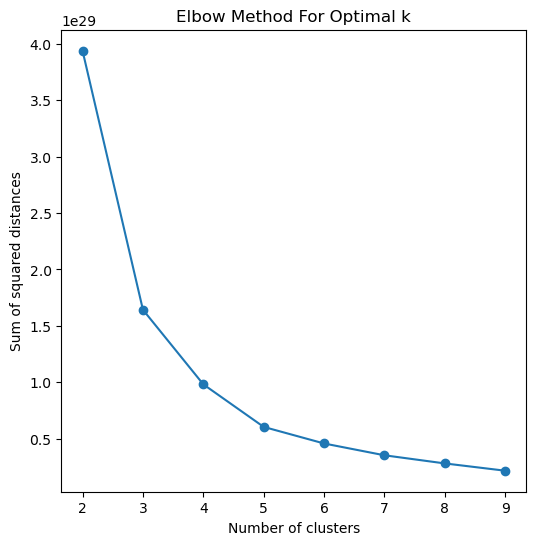

In [12]:
# tune kmeans
# Calculate the sum of squared distances (SSD) for different numbers of clusters
ssd = []
for k in range(2, 10):  # change the range as needed
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=0).fit(features)
    ssd.append(kmeans.inertia_)

# Plot SSD against k
plt.figure(figsize=(6, 6))
plt.plot(range(2, 10), ssd, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The image you provided shows a plot typically used in the "elbow method" for determining the optimal number of clusters in K-means clustering. The x-axis represents the number of clusters, and the y-axis represents the sum of squared distances (SSD) of samples to their closest cluster center.

The "elbow" in the plot is the point at which adding another cluster doesn't provide much better modeling of the data. This is typically where the plot forms an "elbow"-like shape, with a steep decrease before the elbow and a more gradual decrease after.

Looking at the plot you provided, the "elbow" appears to be at `k=3`. This is where the rate of decrease changes most significantly. So, in this case, the optimal number of clusters would be 3.

In [13]:
kmeans = KMeans(n_clusters=3,n_init=10,random_state=0).fit(features)
df['cluster'] = kmeans.labels_

In [14]:
# Move the label column to the end
label = df['label']
df = df.drop(columns=['label'])
df['label'] = label

In [15]:
df

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster,label
0,23,2017,11,18,0.008333,1,0,2,1.000500e+08,1,...,0,0.150000,0,0,1,1.000500e+08,1.000500e+08,1,0,2
1,128,2016,132,44,0.000244,1,0,1,1.000000e+08,1,...,0,0.010742,0,4,18,1.000000e+08,1.000000e+08,1,0,2
2,169,2016,246,0,1.000000,1,0,2,2.000000e+08,1,...,0,0.000000,0,8,35,2.000000e+08,2.000000e+08,1,0,2
3,217,2016,322,72,0.003906,1,0,2,7.120000e+07,1,...,0,0.281250,0,10,46,7.120000e+07,7.120000e+07,1,0,2
4,293,2016,238,144,0.072848,456,0,1,2.000000e+08,1,...,0,10.490171,0,7,34,2.000000e+08,2.000000e+08,456,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916692,30849,2018,330,0,0.111111,1,0,1,1.255809e+09,1,...,0,0.000000,0,11,47,1.255809e+09,1.255809e+09,1,0,3
2916693,2192574,2018,330,0,1.000000,1,0,1,4.409699e+07,1,...,0,0.000000,0,11,47,4.409699e+07,4.409699e+07,1,0,3
2916694,1824270,2018,330,2,12.000000,6,6,35,2.398267e+09,7,...,1,24.000000,36,11,47,5.344682e+10,7.635260e+09,84,0,3
2916695,389289,2018,330,0,0.500000,1,0,1,1.780427e+08,1,...,0,0.000000,0,11,47,1.780427e+08,1.780427e+08,1,0,3


In [16]:
# Define a threshold for the Z-score method
z_threshold = 3

# Create a new DataFrame with only the numerical columns excluding the label
numerical_df = df.drop(columns=['label']).select_dtypes(include=[np.number])

# Calculate the Z-score for each data point
z_scores = np.abs((numerical_df - numerical_df.mean()) / numerical_df.std())

# Identify outliers based on the threshold
outliers = numerical_df[(z_scores > z_threshold).any(axis=1)]

# Remove outliers from the dataset
df = df[(z_scores <= z_threshold).all(axis=1)].copy()

In [17]:
df['label'].value_counts()

3    2671631
2      15256
1       8099
0       6917
Name: label, dtype: int64

In [18]:
df

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster,label
0,23,2017,11,18,0.008333,1,0,2,1.000500e+08,1,...,0,0.150000,0,0,1,1.000500e+08,1.000500e+08,1,0,2
1,128,2016,132,44,0.000244,1,0,1,1.000000e+08,1,...,0,0.010742,0,4,18,1.000000e+08,1.000000e+08,1,0,2
2,169,2016,246,0,1.000000,1,0,2,2.000000e+08,1,...,0,0.000000,0,8,35,2.000000e+08,2.000000e+08,1,0,2
3,217,2016,322,72,0.003906,1,0,2,7.120000e+07,1,...,0,0.281250,0,10,46,7.120000e+07,7.120000e+07,1,0,2
4,293,2016,238,144,0.072848,456,0,1,2.000000e+08,1,...,0,10.490171,0,7,34,2.000000e+08,2.000000e+08,456,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916689,2410962,2018,330,26,1.000000,1,0,2,1.381033e+08,1,...,0,26.000000,0,11,47,1.381033e+08,1.381033e+08,1,0,3
2916690,2404793,2018,330,56,0.041667,1,0,2,3.356822e+08,1,...,0,2.333333,0,11,47,3.356822e+08,3.356822e+08,1,0,3
2916692,30849,2018,330,0,0.111111,1,0,1,1.255809e+09,1,...,0,0.000000,0,11,47,1.255809e+09,1.255809e+09,1,0,3
2916693,2192574,2018,330,0,1.000000,1,0,1,4.409699e+07,1,...,0,0.000000,0,11,47,4.409699e+07,4.409699e+07,1,0,3


The `PowerTransformer` with the `yeo-johnson` method is a form of data normalization. It's a statistical technique used to stabilize variance, make the data more closely resemble a normal distribution, and improve the validity of measures of association.

The Yeo-Johnson transformation is a power transformation technique that supports both positive, zero, and negative values, unlike the Box-Cox transformation which only supports positive values. 

This transformation does not standardize the data to have a mean of 0 and a standard deviation of 1, which is what we refer to when we talk about standardization. 

So, in summary, the `PowerTransformer` with the `yeo-johnson` method is a form of normalization, not standardization.

In [19]:
# Create a PowerTransformer instance
pt = PowerTransformer(method='yeo-johnson')

# Select numerical columns excluding the label
numerical_cols = df.select_dtypes(include=[np.number]).drop(columns=['label']).columns

# Apply the power transformation to numerical columns
df[numerical_cols] = pt.fit_transform(df[numerical_cols])

In [20]:
df

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster,label
0,-2.200465,6.691869e-13,-1.892670,0.378310,-1.155154,-0.709017,-0.343465,0.521575,-0.556439,-0.362158,...,0.0,-0.663055,-0.340715,-1.792756,-1.893674,-0.673996,-0.581985,-0.778954,0.0,2
1,-2.198043,4.126144e-13,-0.381495,0.812989,-1.199514,-0.709017,-0.343465,-1.374059,-0.556838,-0.362158,...,0.0,-0.913038,-0.340715,-0.374862,-0.417609,-0.674366,-0.582384,-0.778954,0.0,2
2,-2.197295,4.126144e-13,0.653242,-1.288582,1.244587,-0.709017,-0.343465,0.521575,-0.046927,-0.362158,...,0.0,-0.934793,-0.340715,0.723158,0.669250,-0.194108,-0.071128,-0.778954,0.0,2
3,-2.196484,4.126144e-13,1.267038,1.047173,-1.179325,-0.709017,-0.343465,0.521575,-0.839304,-0.362158,...,0.0,-0.470924,-0.340715,1.219434,1.295465,-0.934222,-0.864829,-0.778954,0.0,2
4,-2.195300,4.126144e-13,0.585784,1.367866,-0.830044,1.632429,-0.343465,-1.374059,-0.046927,-0.362158,...,0.0,1.412074,-0.340715,0.463936,0.609923,-0.194108,-0.071128,1.476740,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916689,1.349818,9.252044e-13,1.329168,0.558195,1.244587,-0.709017,-0.343465,0.521575,-0.308823,-0.362158,...,0.0,1.636174,-0.340715,1.458230,1.350296,-0.442689,-0.333951,-0.778954,0.0,3
2916690,1.343417,9.252044e-13,1.329168,0.928267,-0.981102,-0.709017,-0.343465,0.521575,0.282527,-0.362158,...,0.0,0.709921,-0.340715,1.458230,1.350296,0.125032,0.260268,-0.778954,0.0,3
2916692,-2.036496,9.252044e-13,1.329168,-1.288582,-0.658593,-0.709017,-0.343465,-1.374059,0.958795,-0.362158,...,0.0,-0.934793,-0.340715,1.458230,1.350296,0.807654,0.943756,-0.778954,0.0,3
2916693,1.120159,9.252044e-13,1.329168,-1.288582,1.244587,-0.709017,-0.343465,-1.374059,-1.278790,-0.362158,...,0.0,-0.934793,-0.340715,1.458230,1.350296,-1.330926,-1.303318,-0.778954,0.0,3


In [21]:
# Feature scaling for all numerical features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [22]:
df

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster,label
0,0.000253,0.857961,0.062835,0.627489,0.012028,0.000000,0.0,0.298088,0.277443,0.0,...,0.0,0.096372,0.0,0.000000,0.038482,0.232624,0.273815,0.000000,0.0,2
1,0.000894,0.715614,0.468752,0.791121,0.000356,0.000000,0.0,0.000000,0.277343,0.0,...,0.0,0.007715,0.0,0.406922,0.442411,0.232539,0.273717,0.000000,0.0,2
2,0.001092,0.715614,0.746693,0.000000,0.643462,0.000000,0.0,0.298088,0.404329,0.0,...,0.0,0.000000,0.0,0.722043,0.739832,0.343862,0.399690,0.000000,0.0,2
3,0.001307,0.715614,0.911565,0.879278,0.005668,0.000000,0.0,0.298088,0.206999,0.0,...,0.0,0.164511,0.0,0.864469,0.911197,0.172304,0.204123,0.000000,0.0,2
4,0.001620,0.715614,0.728573,1.000000,0.097573,0.950441,0.0,0.000000,0.404329,0.0,...,0.0,0.832317,0.0,0.647649,0.723597,0.343862,0.399690,0.913812,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916689,0.940333,1.000000,0.928253,0.695205,0.643462,0.000000,0.0,0.298088,0.339108,0.0,...,0.0,0.911794,0.0,0.933001,0.926201,0.286241,0.334930,0.000000,0.0,3
2916690,0.938638,1.000000,0.928253,0.834516,0.057826,0.000000,0.0,0.298088,0.486375,0.0,...,0.0,0.583298,0.0,0.933001,0.926201,0.417838,0.481345,0.000000,0.0,3
2916692,0.043670,1.000000,0.928253,0.000000,0.142686,0.000000,0.0,0.000000,0.654789,0.0,...,0.0,0.000000,0.0,0.933001,0.926201,0.576069,0.649756,0.000000,0.0,3
2916693,0.879521,1.000000,0.928253,0.000000,0.643462,0.000000,0.0,0.000000,0.097552,0.0,...,0.0,0.000000,0.0,0.933001,0.926201,0.080349,0.096080,0.000000,0.0,3


In [23]:
# df.to_csv('./data/BitcoinHeistDataPreProcessed.csv',index=False)

# Can directly start from here

In [37]:
df=pd.read_csv('../data/BitcoinHeistDataPreProcessed.csv')

In [38]:
df

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster,label
0,0.000253,0.857961,0.062835,0.627489,0.012028,0.000000,0.0,0.298088,0.277443,0.0,...,0.0,0.096372,0.0,0.000000,0.038482,0.232624,0.273815,0.000000,0.0,2
1,0.000894,0.715614,0.468752,0.791121,0.000356,0.000000,0.0,0.000000,0.277343,0.0,...,0.0,0.007715,0.0,0.406922,0.442411,0.232539,0.273717,0.000000,0.0,2
2,0.001092,0.715614,0.746693,0.000000,0.643462,0.000000,0.0,0.298088,0.404329,0.0,...,0.0,0.000000,0.0,0.722043,0.739832,0.343862,0.399690,0.000000,0.0,2
3,0.001307,0.715614,0.911565,0.879278,0.005668,0.000000,0.0,0.298088,0.206999,0.0,...,0.0,0.164511,0.0,0.864469,0.911197,0.172304,0.204123,0.000000,0.0,2
4,0.001620,0.715614,0.728573,1.000000,0.097573,0.950441,0.0,0.000000,0.404329,0.0,...,0.0,0.832317,0.0,0.647649,0.723597,0.343862,0.399690,0.913812,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701898,0.940333,1.000000,0.928253,0.695205,0.643462,0.000000,0.0,0.298088,0.339108,0.0,...,0.0,0.911794,0.0,0.933001,0.926201,0.286241,0.334930,0.000000,0.0,3
2701899,0.938638,1.000000,0.928253,0.834516,0.057826,0.000000,0.0,0.298088,0.486375,0.0,...,0.0,0.583298,0.0,0.933001,0.926201,0.417838,0.481345,0.000000,0.0,3
2701900,0.043670,1.000000,0.928253,0.000000,0.142686,0.000000,0.0,0.000000,0.654789,0.0,...,0.0,0.000000,0.0,0.933001,0.926201,0.576069,0.649756,0.000000,0.0,3
2701901,0.879521,1.000000,0.928253,0.000000,0.643462,0.000000,0.0,0.000000,0.097552,0.0,...,0.0,0.000000,0.0,0.933001,0.926201,0.080349,0.096080,0.000000,0.0,3


# handle class imbalance

In [5]:
# Get the count of the majority class
majority_class_count = df['label'].value_counts().max()

# Calculate the desired number of samples for each minority class
desired_samples = int(majority_class_count * 0.007)

# Define the class distribution for oversampling and undersampling
over_sampling_strategy = {0: desired_samples, 1: desired_samples, 2: desired_samples}
under_sampling_strategy = {3: desired_samples}

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=over_sampling_strategy)
under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)

# Define pipeline
pipeline = Pipeline([('SMOTE', over), ('RandomUnderSampler', under)])

# Apply the pipeline to the data
X, y = pipeline.fit_resample(df.drop('label', axis=1), df['label'])


# Split data

The choice of the test set size or the split ratio between the training and test sets can depend on several factors, including the total amount of data available and the complexity of the model. Here are some general guidelines:

1. **If you have a large dataset (e.g., > 100,000 records):** You can afford to hold out a larger portion of your data for testing. A split like 80/20 or 90/10 for training/test might be appropriate.

2. **If you have a small dataset (e.g., < 1000 records):** You might want to use a smaller test set, like 10-20% of the data, or even consider using cross-validation methods which can be more effective at making the most of limited data.

3. **If you have a moderate-sized dataset (e.g., 1000-100,000 records):** A common choice is to use a 70/30 or 75/25 split for training/test.

Remember, these are just rules of thumb and the optimal split can depend on your specific use case. It's also important to consider whether you need a separate validation set, or if you'll be using cross-validation.

In your case, a test size of 0.2 (or 20%) is a common choice and is likely a reasonable starting point. However, you may want to experiment with different splits and see if it makes a significant difference for your specific model and data.

In [6]:
X

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,merge_behavior,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster
0,0.004565,0.287034,0.901076,0.356743,0.010325,0.185482,0.0,0.000000,0.277343,0.000000,...,0.009000,0.0,0.020214,0.0,0.864469,0.896106,0.232539,0.273717,0.154875,0.0
1,0.003043,0.715614,0.505701,1.000000,0.607370,0.998122,0.0,0.000000,0.285142,0.000000,...,0.000462,0.0,0.974616,0.0,0.406922,0.480341,0.239276,0.281440,0.984836,0.0
2,0.005666,0.715614,0.536601,0.834516,0.000044,0.000000,0.0,0.000000,0.312810,0.951426,...,0.000077,0.0,0.001237,0.0,0.490662,0.517305,0.427275,0.381831,0.250420,0.0
3,0.005666,0.715614,0.531497,0.478639,0.563233,0.185482,0.0,0.558888,0.434381,0.951426,...,0.581020,0.0,0.758084,0.0,0.490662,0.517305,0.427275,0.381831,0.250420,0.0
4,0.006981,0.715614,0.528938,0.427049,0.449610,0.471330,0.0,0.298088,0.312810,0.000000,...,0.186066,0.0,0.635269,0.0,0.490662,0.517305,0.263278,0.308854,0.407422,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74799,0.516304,0.287034,0.015413,0.247242,0.014795,0.296239,0.0,0.000000,0.542940,0.000000,...,0.008632,0.0,0.014636,0.0,0.000000,0.000000,0.469934,0.537779,0.250420,0.0
74800,0.283572,0.287034,0.694137,0.247242,0.068728,0.000000,0.0,0.000000,0.416445,0.000000,...,0.117272,0.0,0.066767,0.0,0.647649,0.674116,0.354677,0.411734,0.000000,0.0
74801,0.995603,1.000000,0.152137,0.744302,0.002841,0.000000,0.0,0.000000,0.000000,0.000000,...,0.004935,0.0,0.045542,0.0,0.119852,0.130697,0.000000,0.000000,0.000000,0.0
74802,0.451524,0.573052,0.455298,0.356743,0.158148,0.000000,0.0,0.000000,0.023267,0.000000,...,0.263100,0.0,0.254840,0.0,0.406922,0.442411,0.019036,0.022899,0.000000,0.0


In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature selection for training data

Original features: Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'n_address_feature', 'quarter_number',
       'is_close_to_holiday', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior',
       'cybercrime_related', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency', 'cluster'],
      dtype='object')
Selected features: Index(['address', 'year', 'day', 'weight', 'neighbors', 'income',
       'n_address_feature', 'quarter_number', 'day_of_week',
       'average_income_per_transaction', 'transaction_count', 'length_weight',
       'month', 'week', 'total_volume', 'average_volume',
       'transaction_frequency'],
      dtype='object')
Not selected features: Index(['length', 'count', 'looped', 'is_close_to_holiday', 'looped_ratio',
       'merge_behavior', 'cybercrime_related', 'count_looped', 'cluster'],
      dty

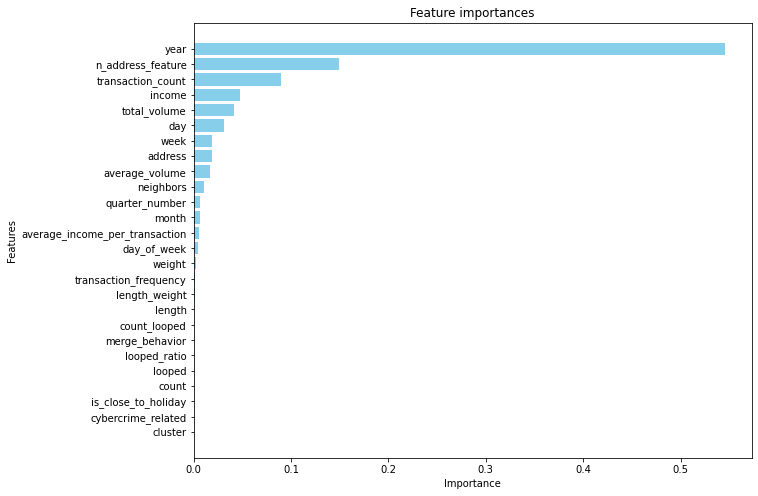

In [7]:
# Feature selection
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)  # Fit on the training data

# Print the feature names before selection
original_feature_names = X_train.columns  # Get feature names from the training data
print('Original features: {}'.format(original_feature_names))

# Get feature importances
importances = gb.feature_importances_

# Create a boolean mask of features selected by the model
mask = importances > 0.001  # adjust threshold as needed

# Apply the mask to the feature dataset
X_train_new = X_train.loc[:, mask]  # Apply mask to the training data
X_test_new = X_test.loc[:, mask]  # Apply the same mask to the testing data

# Print the selected feature names
selected_feature_names = X_train_new.columns
print('Selected features: {}'.format(selected_feature_names))

# Print the features that are not selected
not_selected_feature_names = original_feature_names[~mask]
print('Not selected features: {}'.format(not_selected_feature_names))

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': original_feature_names, 'importance': importances})

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances with feature names
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()  # Reverse the order of features
plt.show()

## threshold tuning for feature selection

In [8]:
# Create copies of the original X_train and X_test
X_train_initial = X_train.copy()
X_test_initial = X_test.copy()

[I 2023-06-27 22:05:46,835] A new study created in memory with name: no-name-f386d093-1fd1-4ec9-99a8-03cf06888e82


Original features: Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'n_address_feature', 'quarter_number',
       'is_close_to_holiday', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior',
       'cybercrime_related', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency', 'cluster'],
      dtype='object')


[I 2023-06-27 22:07:29,473] Trial 0 finished with value: 0.9407585653718346 and parameters: {'threshold': 0.0003600084430046158}. Best is trial 0 with value: 0.9407585653718346.
[I 2023-06-27 22:09:09,720] Trial 1 finished with value: 0.9410259348382415 and parameters: {'threshold': 9.253037760343475e-05}. Best is trial 1 with value: 0.9410259348382415.
[I 2023-06-27 22:10:06,218] Trial 2 finished with value: 0.9381421641648524 and parameters: {'threshold': 0.008906691411892556}. Best is trial 1 with value: 0.9410259348382415.
[I 2023-06-27 22:11:03,175] Trial 3 finished with value: 0.9381421641648524 and parameters: {'threshold': 0.009810608135378651}. Best is trial 1 with value: 0.9410259348382415.
[I 2023-06-27 22:12:22,023] Trial 4 finished with value: 0.9393071311256255 and parameters: {'threshold': 0.0017968849507022345}. Best is trial 1 with value: 0.9410259348382415.
[I 2023-06-27 22:13:19,937] Trial 5 finished with value: 0.9381421641648524 and parameters: {'threshold': 0.0080

Best threshold: 9.253037760343475e-05
Best score: 0.9410259348382415
Selected features: Index(['address', 'year', 'day', 'length', 'weight', 'looped', 'neighbors',
       'income', 'n_address_feature', 'quarter_number', 'day_of_week',
       'average_income_per_transaction', 'transaction_count', 'looped_ratio',
       'merge_behavior', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency'],
      dtype='object')
Not selected features: Index(['count', 'is_close_to_holiday', 'cybercrime_related', 'cluster'], dtype='object')


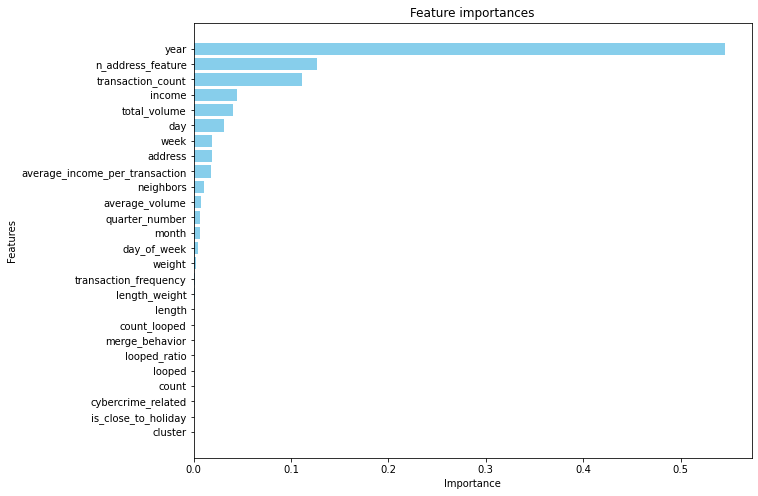

In [9]:
# Feature selection
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)  # Fit on the training data

# Print the feature names before selection
original_feature_names = X_train.columns  # Get feature names from the training data
print('Original features: {}'.format(original_feature_names))

# Get feature importances
importances = gb.feature_importances_

# Define an objective function to be minimized.
def objective(trial, X_train, y_train):
    # Suggest a threshold for the feature selection
    threshold = trial.suggest_float('threshold', 0, 0.01)

    # Create a mask for the current threshold
    mask = importances > threshold

    # Apply the mask to the training data
    X_train_new = X_train.loc[:, mask]
    
    # If all features are filtered out, return a large negative value
    if X_train_new.empty:
        return -1e9
    
    # Fit the model and evaluate its performance
    gb.fit(X_train_new, y_train)
    score = gb.score(X_train_new, y_train)

    # Return the score
    return score

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30)

# Get the best trial
best_trial = study.best_trial

print('Best threshold: {}'.format(best_trial.params['threshold']))
print('Best score: {}'.format(best_trial.value))

# Apply the best threshold to the feature dataset
mask = importances > best_trial.params['threshold']
X_train_new = X_train.loc[:, mask]  # Apply mask to the training data
X_test_new = X_test.loc[:, mask]  # Apply the same mask to the testing data

# Print the selected feature names
selected_feature_names = X_train_new.columns
print('Selected features: {}'.format(selected_feature_names))

# Print the features that are not selected
not_selected_feature_names = original_feature_names[~mask]
print('Not selected features: {}'.format(not_selected_feature_names))

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': original_feature_names, 'importance': importances})

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances with feature names
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()  # Reverse the order of features
plt.show()

In [10]:
# Transfer X_train_new to X_train
X_train = X_train_new.copy()

# Transfer X_test_new to X_test
X_test = X_test_new.copy()

# Update the feature names to match the selected features
selected_feature_names = X_train.columns
print('Updated X_train with selected features: {}'.format(selected_feature_names))

selected_feature_names = X_test.columns
print('Updated X_test with selected features: {}'.format(selected_feature_names))

Updated X_train with selected features: Index(['address', 'year', 'day', 'length', 'weight', 'looped', 'neighbors',
       'income', 'n_address_feature', 'quarter_number', 'day_of_week',
       'average_income_per_transaction', 'transaction_count', 'looped_ratio',
       'merge_behavior', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency'],
      dtype='object')
Updated X_test with selected features: Index(['address', 'year', 'day', 'length', 'weight', 'looped', 'neighbors',
       'income', 'n_address_feature', 'quarter_number', 'day_of_week',
       'average_income_per_transaction', 'transaction_count', 'looped_ratio',
       'merge_behavior', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency'],
      dtype='object')


In [11]:
# # If you want to revert back to the initial X_train and X_test(optional):
# X_train = X_train_initial.copy()
# X_test = X_test_initial.copy()

In [8]:
# selected_features = ['address', 'year', 'day', 'length', 'weight', 'looped', 'neighbors',
#                      'income', 'n_address_feature', 'quarter_number', 'day_of_week',
#                      'average_income_per_transaction', 'transaction_count', 'looped_ratio',
#                      'merge_behavior', 'length_weight', 'count_looped', 'month', 'week',
#                      'total_volume', 'average_volume', 'transaction_frequency']

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]


The image you provided shows a plot of model score (accuracy, presumably) versus the feature importance threshold. The feature importance threshold is used to select features for the model: features with an importance above the threshold are selected, while features with an importance below the threshold are discarded.

The goal is to choose a threshold that results in the highest model score. In the plot you provided, the model score appears to peak at a threshold of approximately 0.01. Therefore, in this case, the optimal feature importance threshold would be 0.01.

However, it's important to note that the choice of threshold also depends on other considerations. For example, if computational efficiency is a concern, you might choose a higher threshold to reduce the number of features and thus the complexity of the model. Conversely, if you want to ensure that no potentially important features are missed, you might choose a lower threshold.

# 1. Xgboost

In [12]:
# Define the model
xg = XGBClassifier()

# Fit the model
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Accuracy of XGBoost: 0.9599857410212993
Prediction time: 0.0199127197265625 seconds
Precision of XGBoost: 0.9602886389005038
Recall of XGBoost: 0.9599857410212993
F1-score of XGBoost: 0.9598138701378524
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5559
           1       0.98      0.99      0.99      5690
           2       0.93      0.98      0.96      5543
           3       0.96      0.91      0.93      5650

    accuracy                           0.96     22442
   macro avg       0.96      0.96      0.96     22442
weighted avg       0.96      0.96      0.96     22442



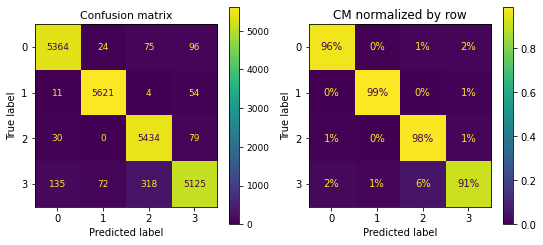

<Figure size 432x288 with 0 Axes>

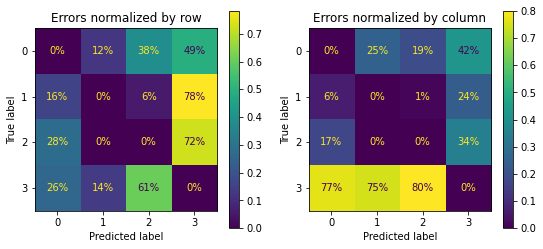

In [13]:
xg_score=xg.score(X_test,y_test)

start_time = time.time()
y_predict=xg.predict(X_test)
end_time = time.time()

prediction_time = end_time - start_time

y_true=y_test
sample_weight = (y_predict != y_true)

print('Accuracy of XGBoost: '+ str(xg_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))

with PdfPages('XGBoost_Confusion_matrix.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[0],
                                            sample_weight=sample_weight,   
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


In [14]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the model
xg = XGBClassifier()

# Define the hyperparameters
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Create a study object
study = optuna.create_study(direction='maximize')

# Define the objective function with cross validation
def objective(trial):
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 10]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200, 300]),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 5, 10]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    xg = XGBClassifier(**params)
    scores = cross_val_score(xg, X_train, y_train, cv=5)
    return scores.mean()

# Run the optimization
study.optimize(objective, n_trials=30)

# Print the result
best_params = study.best_params
best_score = study.best_value
print(f'Best score: {best_score}\n')
print(f'Optimized parameters: {best_params}\n')

# Fit the model with the optimized parameters
xg_opt = XGBClassifier(**best_params)
xg_opt.fit(X_train, y_train)

# Save the model to a file
pickle.dump(xg_opt, open("xgboost_optuna_model.pkl", "wb"))

[I 2023-06-27 22:46:35,677] A new study created in memory with name: no-name-f702eada-fe1b-46af-b1af-1e593f3f2e5b
[I 2023-06-27 22:47:42,071] Trial 0 finished with value: 0.9568389836078179 and parameters: {'max_depth': 5, 'learning_rate': 0.07873312190910145, 'n_estimators': 300, 'gamma': 0.06843374351044525, 'min_child_weight': 5, 'subsample': 0.8525671822683126, 'colsample_bytree': 0.5527285274764355}. Best is trial 0 with value: 0.9568389836078179.
[I 2023-06-27 22:47:57,060] Trial 1 finished with value: 0.9306558437546524 and parameters: {'max_depth': 7, 'learning_rate': 0.017380860389173573, 'n_estimators': 50, 'gamma': 0.10864095696147001, 'min_child_weight': 1, 'subsample': 0.7457027287016251, 'colsample_bytree': 0.5847906389659926}. Best is trial 0 with value: 0.9568389836078179.
[I 2023-06-27 22:48:26,949] Trial 2 finished with value: 0.9007487531873768 and parameters: {'max_depth': 3, 'learning_rate': 0.019176294723665232, 'n_estimators': 200, 'gamma': 0.07795436016605398, '

[I 2023-06-27 23:06:28,543] Trial 24 finished with value: 0.9599710179116047 and parameters: {'max_depth': 10, 'learning_rate': 0.05570854479422755, 'n_estimators': 200, 'gamma': 0.007614549573095111, 'min_child_weight': 10, 'subsample': 0.8932970237605262, 'colsample_bytree': 0.5866444083764976}. Best is trial 23 with value: 0.9610213851953114.
[I 2023-06-27 23:07:48,445] Trial 25 finished with value: 0.9615752540437024 and parameters: {'max_depth': 10, 'learning_rate': 0.08801996430543457, 'n_estimators': 200, 'gamma': 0.04265157891257164, 'min_child_weight': 5, 'subsample': 0.8778610685522019, 'colsample_bytree': 0.5976519221785005}. Best is trial 25 with value: 0.9615752540437024.
[I 2023-06-27 23:08:46,971] Trial 26 finished with value: 0.9589970284095513 and parameters: {'max_depth': 7, 'learning_rate': 0.08558874723932673, 'n_estimators': 200, 'gamma': 0.03646305612242942, 'min_child_weight': 10, 'subsample': 0.8808480397057998, 'colsample_bytree': 0.5873944740639433}. Best is t

Best score: 0.9615752540437024

Optimized parameters: {'max_depth': 10, 'learning_rate': 0.08801996430543457, 'n_estimators': 200, 'gamma': 0.04265157891257164, 'min_child_weight': 5, 'subsample': 0.8778610685522019, 'colsample_bytree': 0.5976519221785005}



Accuracy of XGBoost: 0.9621691471348365
Prediction time: 0.05974125862121582 seconds
Precision of XGBoost: 0.9624110293899752
Recall of XGBoost: 0.9621691471348365
F1-score of XGBoost: 0.9620227571916335
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5559
           1       0.99      0.99      0.99      5690
           2       0.94      0.98      0.96      5543
           3       0.96      0.91      0.93      5650

    accuracy                           0.96     22442
   macro avg       0.96      0.96      0.96     22442
weighted avg       0.96      0.96      0.96     22442



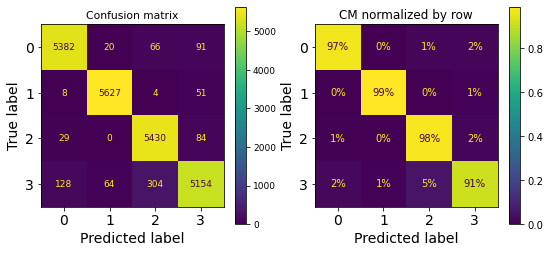

<Figure size 432x288 with 0 Axes>

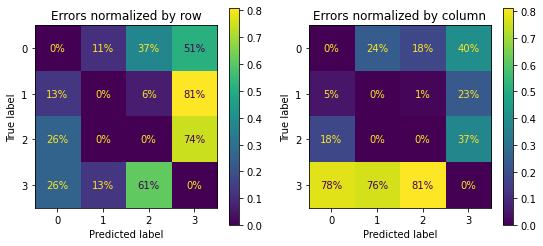

In [15]:
# Load the model from the file
xg_opt = pickle.load(open("xgboost_optuna_model.pkl", "rb"))

# Evaluation on the test set
xg_score=xg_opt.score(X_test,y_test)

start_time = time.time()
y_predict=xg_opt.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

y_true=y_test
sample_weight = (y_predict != y_true)

print('Accuracy of XGBoost: '+ str(xg_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))

with PdfPages('XGBoost_Confusion_matrix_tuned.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true,y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


# 2. RandomForest

In [32]:
# Define the model
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)

start_time = time.time()
y_predict = rf.predict(X_test)
end_time = time.time()

prediction_time = end_time - start_time

y_true=y_test
sample_weight = (y_predict != y_true)

Accuracy of RandomForest: 0.956019962570181
Prediction time: 0.23851227760314941 seconds
Precision of RandomForest: 0.9561303146010326
Recall of RandomForest: 0.956019962570181
F1-score of RandomForest: 0.9558565998227
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5559
           1       0.98      0.99      0.98      5690
           2       0.93      0.97      0.95      5543
           3       0.95      0.91      0.93      5650

    accuracy                           0.96     22442
   macro avg       0.96      0.96      0.96     22442
weighted avg       0.96      0.96      0.96     22442



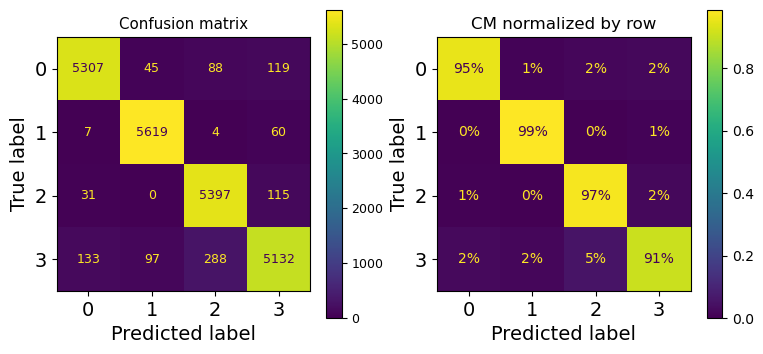

<Figure size 640x480 with 0 Axes>

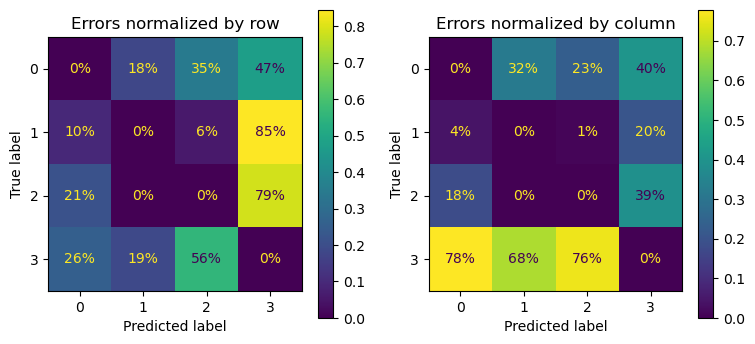

In [33]:
rf_score = rf.score(X_test, y_test)

print('Accuracy of RandomForest: '+ str(rf_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RandomForest: '+(str(precision)))
print('Recall of RandomForest: '+(str(recall)))
print('F1-score of RandomForest: '+(str(fscore)))
print(classification_report(y_true, y_predict))

with PdfPages('RandomForest_Confusion_matrix.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            sample_weight=sample_weight,   
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


In [28]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the model
rf = RandomForestClassifier()

# Create a study object
study = optuna.create_study(direction='maximize')

# Define the objective function with cross validation
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    rf = RandomForestClassifier(**params)
    scores = cross_val_score(rf, X_train, y_train, cv=5)
    return scores.mean()

# Run the optimization
study.optimize(objective, n_trials=30)

# Print the result
best_params = study.best_params
best_score = study.best_value
print(f'Best score: {best_score}\n')
print(f'Optimized parameters: {best_params}\n')

# Fit the model with the optimized parameters
rf_opt = RandomForestClassifier(**best_params)
rf_opt.fit(X_train, y_train)

# Save the model to a file
pickle.dump(rf_opt, open("randomforest_optuna_model.pkl", "wb"))

[I 2023-06-28 22:28:36,543] A new study created in memory with name: no-name-39cdcd75-8ad3-4056-af72-dc01c63814f9
[I 2023-06-28 22:29:04,251] Trial 0 finished with value: 0.9505749222946387 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'auto'}. Best is trial 0 with value: 0.9505749222946387.
[I 2023-06-28 22:29:59,217] Trial 1 finished with value: 0.9502693655780584 and parameters: {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9505749222946387.
[I 2023-06-28 22:30:57,401] Trial 2 finished with value: 0.9536878616971123 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.9536878616971123.
[I 2023-06-28 22:32:22,256] Trial 3 finished with value: 0.9512242492372069 and parameters: {'n_estimators': 300, 'max_depth': 40, 

Best score: 0.9554830249591568

Optimized parameters: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}



Accuracy of RandomForest: 0.9564209963461368
Prediction time: 1.0477261543273926 seconds
Precision of RandomForest: 0.9565314706900193
Recall of RandomForest: 0.9564209963461368
F1-score of RandomForest: 0.9562974743345438
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5559
           1       0.98      0.99      0.98      5690
           2       0.94      0.97      0.95      5543
           3       0.94      0.91      0.93      5650

    accuracy                           0.96     22442
   macro avg       0.96      0.96      0.96     22442
weighted avg       0.96      0.96      0.96     22442



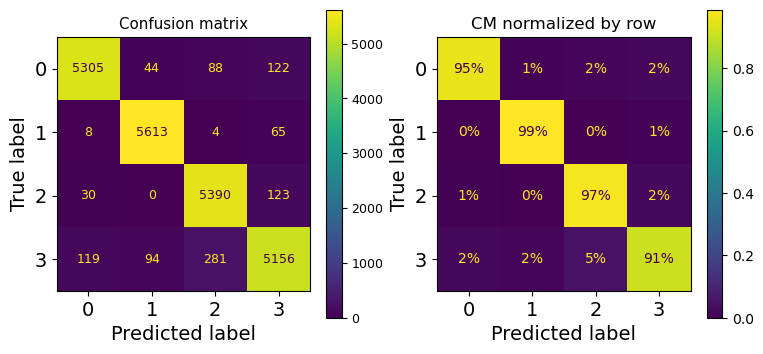

<Figure size 640x480 with 0 Axes>

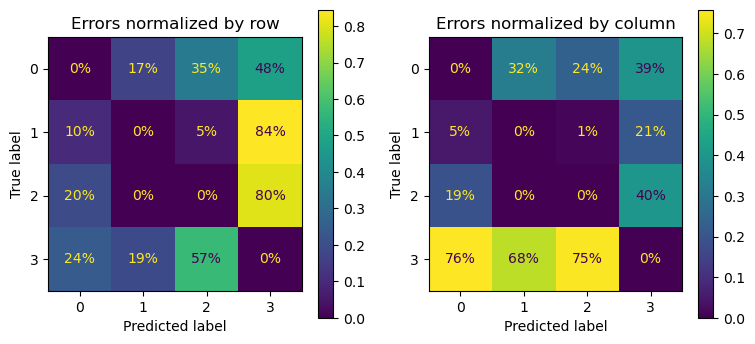

In [29]:
# Load the model from the file
rf_opt = pickle.load(open("randomforest_optuna_model.pkl", "rb"))

# Evaluation on the test set
rf_score = rf_opt.score(X_test, y_test)

start_time = time.time()
y_predict = rf_opt.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

y_true=y_test
sample_weight = (y_predict != y_true)

print('Accuracy of RandomForest: '+ str(rf_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RandomForest: '+(str(precision)))
print('Recall of RandomForest: '+(str(recall)))
print('F1-score of RandomForest: '+(str(fscore)))
print(classification_report(y_true, y_predict))

with PdfPages('RandomForest_Confusion_matrix_tuned.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


# 3. Decision Tree

In [20]:
# Define the model
dt = DecisionTreeClassifier()

# Fit the model
dt.fit(X_train, y_train)

start_time = time.time()
y_predict = dt.predict(X_test)
end_time = time.time()

prediction_time = end_time - start_time

y_true=y_test
sample_weight = (y_predict != y_true)

Accuracy of DecisionTree: 0.9387309508956421
Prediction time: 0.004979133605957031 seconds
Precision of DecisionTree: 0.9387210818302025
Recall of DecisionTree: 0.9387309508956421
F1-score of DecisionTree: 0.9387149521990094
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5559
           1       0.98      0.98      0.98      5690
           2       0.93      0.93      0.93      5543
           3       0.90      0.90      0.90      5650

    accuracy                           0.94     22442
   macro avg       0.94      0.94      0.94     22442
weighted avg       0.94      0.94      0.94     22442



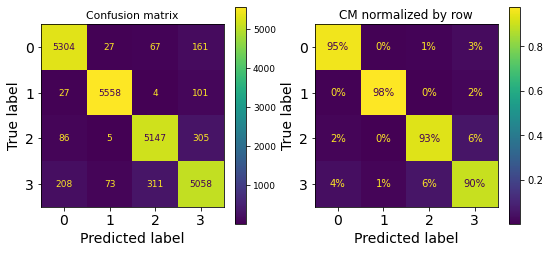

<Figure size 432x288 with 0 Axes>

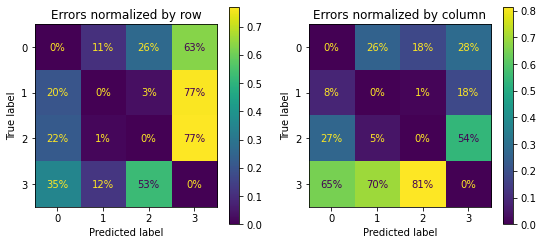

In [21]:
dt_score = dt.score(X_test, y_test)

print('Accuracy of DecisionTree: '+ str(dt_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DecisionTree: '+(str(precision)))
print('Recall of DecisionTree: '+(str(recall)))
print('F1-score of DecisionTree: '+(str(fscore)))
print(classification_report(y_true, y_predict))

with PdfPages('DecisionTree_Confusion_matrix.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


In [22]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a study object
study = optuna.create_study(direction='maximize')

# Define the objective function with cross validation
def objective(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15)
    }
    dt = DecisionTreeClassifier(**params)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    return scores.mean()

# Run the optimization
study.optimize(objective, n_trials=30)

# Print the result
best_params = study.best_params
best_score = study.best_value
print(f'Best score: {best_score}\n')
print(f'Optimized parameters: {best_params}\n')

# Fit the model with the optimized parameters
dt_opt = DecisionTreeClassifier(**best_params)
dt_opt.fit(X_train, y_train)
# Save the model to a file
pickle.dump(dt_opt, open("decisiontree_optuna_model.pkl", "wb"))

[I 2023-06-28 00:37:34,911] A new study created in memory with name: no-name-de369090-59e9-41ba-8632-a308160dfc21
[I 2023-06-28 00:37:39,029] Trial 0 finished with value: 0.939364413508431 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.939364413508431.
[I 2023-06-28 00:37:39,522] Trial 1 finished with value: 0.9273137144756604 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.939364413508431.
[I 2023-06-28 00:37:40,022] Trial 2 finished with value: 0.9284022569732041 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.939364413508431.
[I 2023-06-28 00:37:43,961] Trial 3 finished with value: 0.9387723785641962 and parameters: {'criterion': 'entropy', 'splitter': 'best

Best score: 0.9407395272371598

Optimized parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 8}



Accuracy of DecisionTree: 0.9437215934408698
Prediction time: 0.004978656768798828 seconds
Precision of DecisionTree: 0.9442796857531569
Recall of DecisionTree: 0.9437215934408698
F1-score of DecisionTree: 0.9433509246649306
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5559
           1       0.98      0.98      0.98      5690
           2       0.91      0.97      0.94      5543
           3       0.94      0.87      0.91      5650

    accuracy                           0.94     22442
   macro avg       0.94      0.94      0.94     22442
weighted avg       0.94      0.94      0.94     22442



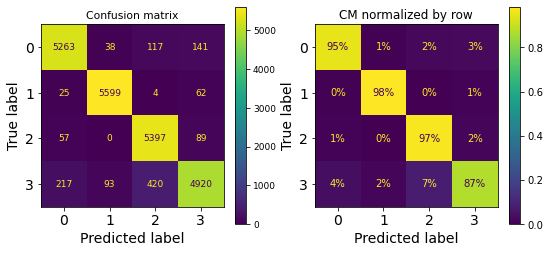

<Figure size 432x288 with 0 Axes>

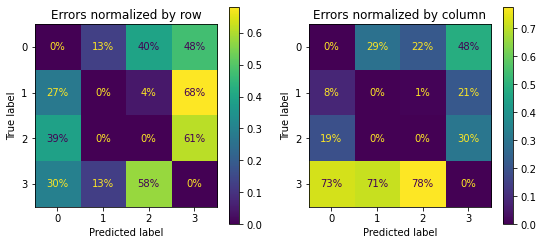

In [23]:
# Load the model from the file
dt_opt = pickle.load(open("decisiontree_optuna_model.pkl", "rb"))

# Evaluation on the test set
dt_score = dt_opt.score(X_test, y_test)
start_time = time.time()
y_predict = dt_opt.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
y_true=y_test
sample_weight = (y_predict != y_true)

print('Accuracy of DecisionTree: '+ str(dt_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DecisionTree: '+(str(precision)))
print('Recall of DecisionTree: '+(str(recall)))
print('F1-score of DecisionTree: '+(str(fscore)))
print(classification_report(y_true, y_predict))

with PdfPages('DecisionTree_Confusion_matrix_tuned.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


# 4. Stacking

In [24]:
# Define the base models
rf = RandomForestClassifier()
xgb = XGBClassifier()
dt = DecisionTreeClassifier()

# Define meta learner model
mlp = MLPClassifier(max_iter=200, verbose=True)

# Define the stacking ensemble
model = StackingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('dt', dt)], final_estimator=mlp, cv=5)

# Fit the model on our training data
model.fit(X_train, y_train)

start_time = time.time()
y_predict = model.predict(X_test)
end_time = time.time()

prediction_time = end_time - start_time

y_true=y_test
sample_weight = (y_predict != y_true)

Iteration 1, loss = 0.31061651
Iteration 2, loss = 0.13027102
Iteration 3, loss = 0.12659640
Iteration 4, loss = 0.12510307
Iteration 5, loss = 0.12389827
Iteration 6, loss = 0.12296326
Iteration 7, loss = 0.12193262
Iteration 8, loss = 0.12089639
Iteration 9, loss = 0.12010557
Iteration 10, loss = 0.11939052
Iteration 11, loss = 0.11837985
Iteration 12, loss = 0.11788669
Iteration 13, loss = 0.11712517
Iteration 14, loss = 0.11686638
Iteration 15, loss = 0.11646990
Iteration 16, loss = 0.11589867
Iteration 17, loss = 0.11577725
Iteration 18, loss = 0.11554572
Iteration 19, loss = 0.11501420
Iteration 20, loss = 0.11520331
Iteration 21, loss = 0.11448478
Iteration 22, loss = 0.11417827
Iteration 23, loss = 0.11424670
Iteration 24, loss = 0.11401299
Iteration 25, loss = 0.11391782
Iteration 26, loss = 0.11386519
Iteration 27, loss = 0.11361926
Iteration 28, loss = 0.11332267
Iteration 29, loss = 0.11336095
Iteration 30, loss = 0.11324958
Iteration 31, loss = 0.11297110
Iteration 32, los

Accuracy of StackingClassifier: 0.9619463505926388
Prediction time: 0.48891234397888184 seconds
Precision of StackingClassifier: 0.9619771734719249
Recall of StackingClassifier: 0.9619463505926388
F1-score of StackingClassifier: 0.9618188646770158
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5559
           1       0.99      0.99      0.99      5690
           2       0.94      0.97      0.96      5543
           3       0.95      0.92      0.93      5650

    accuracy                           0.96     22442
   macro avg       0.96      0.96      0.96     22442
weighted avg       0.96      0.96      0.96     22442



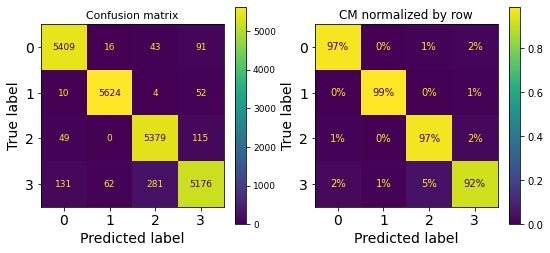

<Figure size 432x288 with 0 Axes>

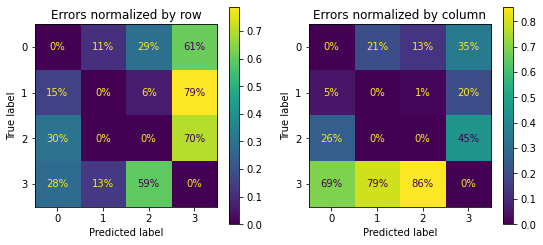

In [25]:
model_score = model.score(X_test, y_test)

print('Accuracy of StackingClassifier: '+ str(model_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of StackingClassifier: '+(str(precision)))
print('Recall of StackingClassifier: '+(str(recall)))
print('F1-score of StackingClassifier: '+(str(fscore)))
print(classification_report(y_true, y_predict))

with PdfPages('StackingClassifier_Confusion_matrix.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again


In [26]:
import optuna
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base models
rf = rf_opt
xgb = xg_opt
dt = dt_opt

# Create a study object
study = optuna.create_study(direction='maximize')

# Define the objective function
def objective(trial):
    layer_sizes = trial.suggest_categorical('hidden_layer_sizes', ['50_50', '100'])
    layer_sizes = tuple(map(int, layer_sizes.split('_'))) if '_' in layer_sizes else int(layer_sizes)
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    
    # Define meta learner model with the suggested parameters
    mlp = MLPClassifier(hidden_layer_sizes=layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=200)

    # Define the stacking ensemble with the new meta learner
    model = StackingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('dt', dt)], final_estimator=mlp, cv=5)

    # Perform cross validation and return the mean score
    scores = cross_val_score(model, X_train, y_train, cv=5)
    return scores.mean()  

# Run the optimization
study.optimize(objective, n_trials=30)  

# Get the best score and parameters
best_score = study.best_value
best_params = study.best_params

# Print the result
print(f'Best score: {best_score}\n')
print(f'Optimized parameters: {best_params}\n')

# Define the best model using the optimized parameters
layer_sizes = tuple(map(int, best_params['hidden_layer_sizes'].split('_'))) if '_' in best_params['hidden_layer_sizes'] else int(best_params['hidden_layer_sizes'])
mlp = MLPClassifier(hidden_layer_sizes=layer_sizes, alpha=best_params['alpha'], learning_rate_init=best_params['learning_rate_init'], max_iter=200)
model = StackingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('dt', dt)], final_estimator=mlp, cv=5)

# Fit the model and evaluate it as before
model.fit(X_train, y_train)

# Save the model to a file
pickle.dump(model, open("stacking_optuna_model.pkl", "wb"))

[I 2023-06-28 00:41:25,854] A new study created in memory with name: no-name-27814a84-dacd-4b39-a725-c5e78f141cbf
[I 2023-06-28 01:15:32,015] Trial 0 finished with value: 0.9620908765579094 and parameters: {'hidden_layer_sizes': '50_50', 'alpha': 0.0018138928615867164, 'learning_rate_init': 0.0001244026029229383}. Best is trial 0 with value: 0.9620908765579094.
[I 2023-06-28 01:43:06,086] Trial 1 finished with value: 0.9585195628731948 and parameters: {'hidden_layer_sizes': '50_50', 'alpha': 0.005356366261929298, 'learning_rate_init': 0.06193696477329333}. Best is trial 0 with value: 0.9620908765579094.
[I 2023-06-28 02:17:09,402] Trial 2 finished with value: 0.9624919187226466 and parameters: {'hidden_layer_sizes': '50_50', 'alpha': 0.0007005756483303174, 'learning_rate_init': 0.00018803473842393673}. Best is trial 2 with value: 0.9624919187226466.
[I 2023-06-28 02:43:43,242] Trial 3 finished with value: 0.9613078579521701 and parameters: {'hidden_layer_sizes': '100', 'alpha': 0.00018

Best score: 0.9624919187226466

Optimized parameters: {'hidden_layer_sizes': '50_50', 'alpha': 0.0007005756483303174, 'learning_rate_init': 0.00018803473842393673}



Accuracy of StackingClassifier: 0.9624365029854737
Prediction time: 1.8222887516021729 seconds
Precision of StackingClassifier: 0.9625829569642195
Recall of StackingClassifier: 0.9624365029854737
F1-score of StackingClassifier: 0.9623144759178868
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5559
           1       0.99      0.99      0.99      5690
           2       0.94      0.98      0.96      5543
           3       0.95      0.92      0.93      5650

    accuracy                           0.96     22442
   macro avg       0.96      0.96      0.96     22442
weighted avg       0.96      0.96      0.96     22442



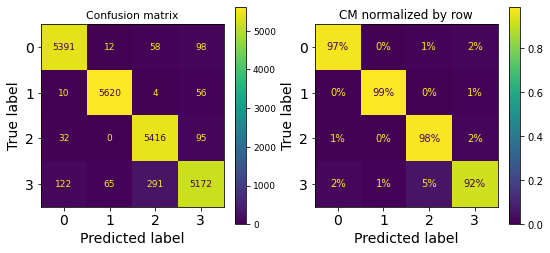

<Figure size 432x288 with 0 Axes>

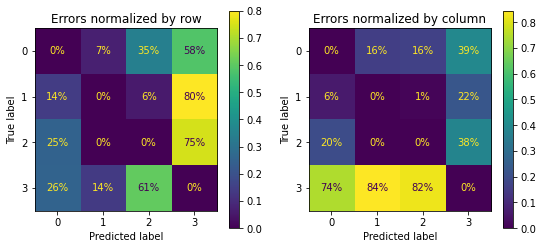

In [27]:
# Load the model from the file
model = pickle.load(open("stacking_optuna_model.pkl", "rb"))

# Evaluation on the test set
model_score = model.score(X_test, y_test)
start_time = time.time()
y_predict = model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
y_true=y_test
sample_weight = (y_predict != y_true)

model_score = model.score(X_test, y_test)

print('Accuracy of StackingClassifier: '+ str(model_score))
print('Prediction time: '+ str(prediction_time) + ' seconds')
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of StackingClassifier: '+(str(precision)))
print('Recall of StackingClassifier: '+(str(recall)))
print('F1-score of StackingClassifier: '+(str(fscore)))
print(classification_report(y_true, y_predict))

with PdfPages('StackingClassifier_Confusion_matrix_tuned.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            normalize="true", values_format=".0%")
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[0],
                                            sample_weight=sample_weight,    
                                            normalize="true", values_format=".0%")
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_true, y_predict, ax=axs[1],
                                            sample_weight=sample_weight,    
                                            normalize="pred", values_format=".0%")
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

plt.rc('font', size=14)  # make fonts great again
